### Let's load in all the results and transform them as necessary

In [83]:
import pickle
import numpy as np
import pandas as pd
import igraph as ig
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

In [84]:
from dataclasses import dataclass

@dataclass
class AllSimulationResults:
    emotion_histories: list
    avg_emotions: list
    interventions: list
    G_networks: list
    DG_networks: list
    absorption_dicts: list
    initial_conditions: list
    sentiment_graphs: list

In [ ]:
populationSize = 15
runs = 14
max_iterations = 260

# No internvention results
all_results_path_plain = r"R:\sescott1\Masters\523\Simulation\Network\Bipartite\No_Intervention\08_31_2025\all_results.pkl"
heatmaps_path_low = r"R:\sescott1\Masters\523\Simulation\Network\Bipartite\No_Intervention\08_31_2025\initial_conditions_heatmaps.pkl"

with open(all_results_path_plain, "rb") as f:
    all_results_wo = pickle.load(f)
with open(all_results_path_plain, "rb") as f:
    heatmaps_wo = pickle.load(f)


# High aperture results
all_results_path_high = r"R:\sescott1\Masters\523\Simulation\Network\Bipartite\High_Aperture\08_31_2025\all_results.pkl"
heatmaps_path_high = r"R:\sescott1\Masters\523\Simulation\Network\Bipartite\High_Aperture\08_31_2025\initial_conditions_heatmaps.pkl"

with open(all_results_path_high, "rb") as f:
    all_results_H = pickle.load(f)
with open(all_results_path_high, "rb") as f:
    heatmaps_H = pickle.load(f)


# Low aperture results
all_results_path_low = r"R:\sescott1\Masters\523\Simulation\Network\Low_Aperture\08_31_2025\all_results.pkl"
heatmaps_path_low = r"R:\sescott1\Masters\523\Simulation\Network\Low_Aperture\08_31_2025\initial_conditions_heatmaps.pkl"
with open(all_results_path_high, "rb") as f:
    all_results_L = pickle.load(f)
with open(all_results_path_high, "rb") as f:
    heatmaps_L = pickle.load(f)

In [86]:
def create_intervention_matrix(all_results):
    '''
    Create a Boolean matrix saying during which timesteps did the leader intervened (0=no, 1=yes) for all simulation runs
    '''
    all_interventions = all_results.interventions
    interventions_summary_df = pd.DataFrame({
        "Run": list(range(1, runs + 1)),
        "Intervention_Timesteps": [','.join(map(str, run)) for run in all_interventions],
        "Num_Interventions": [len(run) for run in all_interventions]
    })

    binary_matrix = np.zeros((runs, max_iterations+1), dtype=int)  # time 0 to 259 for 260 timesteps
    for i, run in enumerate(all_interventions):
        for t in run:
            binary_matrix[i, t] = 1

    interventions_bool_df = pd.DataFrame(binary_matrix).T  # shape: (max_iterations, runs)
    
    return interventions_bool_df, interventions_summary_df

interventions_bool_H, interventions_summary_H = create_intervention_matrix(all_results_H)
interventions_bool_L, interventions_summary_L = create_intervention_matrix(all_results_L)

In [ ]:
def create_avg_emotions_matrix(all_results):
    '''
    Convert avg_emotions into a dataframe
    '''
    data = all_results.avg_emotions  # list of lists, one per run
    df_avg_emotions = pd.DataFrame(data).T  # transpose so rows = timesteps, cols = runs
    df_avg_emotions.columns = [f"Run_{i}" for i in range(len(data))]
    df_avg_emotions.insert(0, "Time", df_avg_emotions.index)
    #df_avg_emotions.reset_index(drop=True, inplace=True)
    return df_avg_emotions

dfWithout = create_avg_emotions_matrix(all_results_wo)
dfHigh = create_avg_emotions_matrix(all_results_H)
dfLow = create_avg_emotions_matrix(all_results_L)

In [88]:
dfHigh.head()

,Time,Run_0,Run_1,Run_2,Run_3,Run_4,Run_5,Run_6,Run_7,Run_8,Run_9,Run_10,Run_11,Run_12,Run_13
0,0,-0.217665,-0.171780,-0.195938,-0.196362,-0.298745,-0.180584,-0.188684,-0.208991,-0.261212,-0.273198,-0.155776,-0.188996,-0.225085,-0.264888
1,1,-0.240909,-0.183562,-0.201571,-0.223344,-0.302839,-0.192916,-0.182686,-0.222227,-0.248582,-0.360972,-0.166542,-0.171940,-0.233420,-0.306025
2,2,-0.265084,-0.192520,-0.209374,-0.249432,-0.305659,-0.196478,-0.181112,-0.226769,-0.241336,-0.379584,-0.184024,-0.165150,-0.246747,-0.391500
3,3,-0.292838,-0.197046,-0.214804,-0.272458,-0.311971,-0.205690,-0.180389,-0.234946,-0.230529,-0.426859,-0.201907,-0.161326,-0.260808,-0.440983
4,4,-0.326908,-0.199983,-0.221631,-0.295690,-0.316081,-0.212411,-0.182143,-0.242075,-0.222962,-0.489468,-0.232649,-0.159255,-0.272584,-0.473001


# Statistical Analysis and Structural Analysis

Let us first see the evolution graphs and the initial conditions of the agent characteristics which led to those results to get a preliminary sense of those interaction dynamics

# Emotion evolution graphs with heatmaps of initial conditions
from IPython.display import display
from pathlib import Path


# Create heatmaps showing us the initial agent characteristics
heatmaps = []
for i, df in enumerate(all_results.initial_conditions):
    plt.figure(figsize=(8, 6))
    sns.heatmap(df.round(3), annot=True, cmap="coolwarm")
    plt.title(f"Heatmap of Initial Agent Parameters: Simulation {i}")
    heatmaps.append(plt.gcf())  # get current figure and store it
    plt.close()


# Display and save images
parentfolder = "R:\sescott1\Masters\523\Simulation\Network"  # main folder under which you want the results to go
stylefolder = Path(parentfolder)/f"{style}_Aperture"  # make the folder under which to save the results to
stylefolder.mkdir(parents=True, exist_ok=True)

for i, (img, hm) in enumerate(zip(all_results.sentiment_graphs, heatmaps)):
    # Create subfolder for this run
    run_folder = stylefolder / f"Run_{i}"
    run_folder.mkdir(exist_ok=True)
    
    display(img)
    display(hm)
    
    # Save the images
    sentiment_path = run_folder / "sentiment.png"
    img.savefig(sentiment_path, bbox_inches='tight')

    heatmap_path = run_folder / "heatmap.png"
    hm.savefig(heatmap_path, bbox_inches='tight')

## Statistics Time!
Remember, our focus is primarily on the dynamics of agent interactions, and how leadership influences those dynamics. We will give a brief explaination of the characteristics to help contextualize the simulation results, but that was what Bosse et al. worked on, so it will not be given as much attention here.

There's also probably a better way of doing the below. Perhaps something more explicitly comparative... future problem

### No Intervention

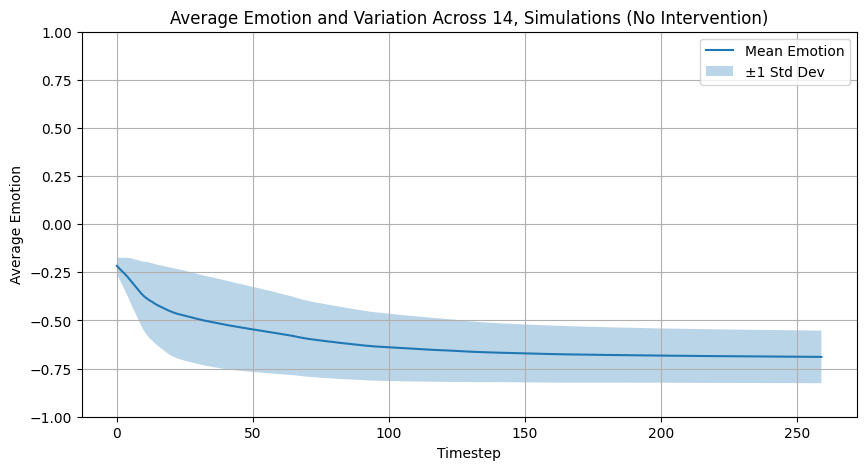

In [89]:
# Simple Statistics
style = 'No Intervention'
mean_emotion_per_timestep = dfWithout.iloc[:, 1:].mean(axis=1)
std_emotion_per_timestep = dfWithout.iloc[:, 1:].std(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(dfWithout.index, mean_emotion_per_timestep, label="Mean Emotion")
plt.fill_between(dfWithout.index,
                 mean_emotion_per_timestep - std_emotion_per_timestep,
                 mean_emotion_per_timestep + std_emotion_per_timestep,
                 alpha=0.3, label="±1 Std Dev")
plt.title(f"Average Emotion and Variation Across {runs}, Simulations ({style})")
plt.xlabel("Timestep")
plt.ylabel("Average Emotion")
plt.ylim(-1, 1)
plt.legend()
plt.grid(True)
plt.show()

In [90]:
print(f"Mean: {mean_emotion_per_timestep}")
print(f"Std Dev: {std_emotion_per_timestep}")
cv_emotion_per_timestep = std_emotion_per_timestep / mean_emotion_per_timestep.abs()

sig_cv = cv_emotion_per_timestep[cv_emotion_per_timestep > 1]
if sig_cv.empty:
    print("No significant coefficient of variation found.")
else:
    print(sig_cv)

Mean: 0     -0.216279
1     -0.231252
2     -0.245341
3     -0.259468
4     -0.274774
         ...   
255   -0.688860
256   -0.688975
257   -0.689053
258   -0.689132
259   -0.689224
Length: 260, dtype: float64
Std Dev: 0      0.042775
1      0.057361
2      0.070481
3      0.085228
4      0.100005
         ...   
255    0.136917
256    0.136842
257    0.136799
258    0.136752
259    0.136701
Length: 260, dtype: float64
No significant coefficient of variation found.


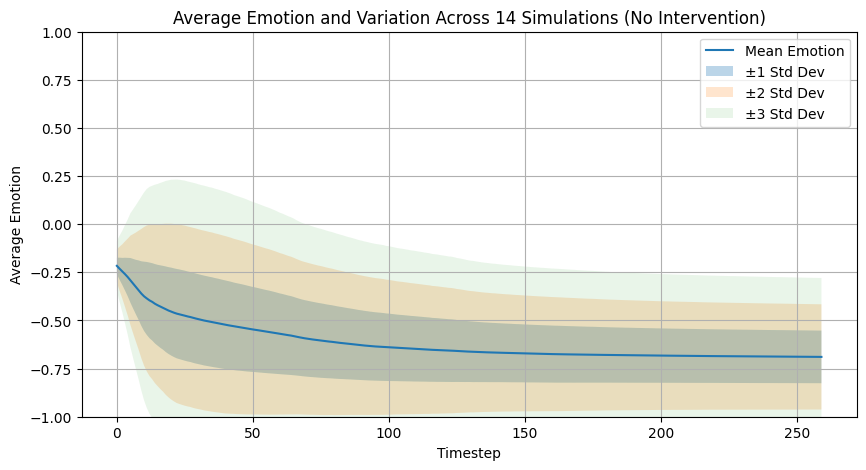

In [91]:
plt.figure(figsize=(10, 5))
plt.plot(dfWithout.index, mean_emotion_per_timestep, label="Mean Emotion")

# ±1 Std Dev
plt.fill_between(dfWithout.index,
                 mean_emotion_per_timestep - std_emotion_per_timestep,
                 mean_emotion_per_timestep + std_emotion_per_timestep,
                 alpha=0.3, label="±1 Std Dev")

# ±2 Std Dev
plt.fill_between(dfWithout.index,
                 mean_emotion_per_timestep - 2 * std_emotion_per_timestep,
                 mean_emotion_per_timestep + 2 * std_emotion_per_timestep,
                 alpha=0.2, label="±2 Std Dev")

# ±3 Std Dev
plt.fill_between(dfWithout.index,
                 mean_emotion_per_timestep - 3 * std_emotion_per_timestep,
                 mean_emotion_per_timestep + 3 * std_emotion_per_timestep,
                 alpha=0.1, label="±3 Std Dev")

plt.title(f"Average Emotion and Variation Across {runs} Simulations ({style})")
plt.xlabel("Timestep")
plt.ylabel("Average Emotion")
plt.ylim(-1, 1)
plt.legend()
plt.grid(True)
plt.show()

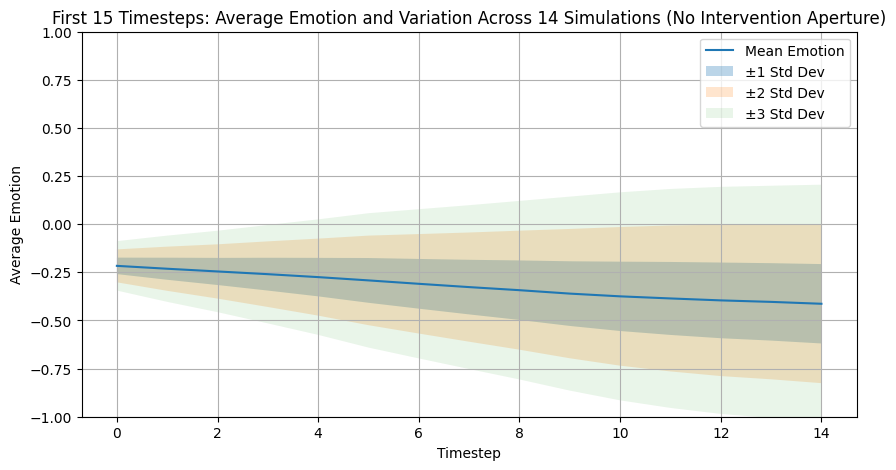

In [92]:
# Zooming in on the first 15 timesteps
df = dfWithout.iloc[:15,:]
mean_emotion_per_timestep = df.iloc[:, 1:].mean(axis=1)
std_emotion_per_timestep = df.iloc[:, 1:].std(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(df.index, mean_emotion_per_timestep, label="Mean Emotion")

# ±1 Std Dev
plt.fill_between(df.index,
                 mean_emotion_per_timestep - std_emotion_per_timestep,
                 mean_emotion_per_timestep + std_emotion_per_timestep,
                 alpha=0.3, label="±1 Std Dev")

# ±2 Std Dev
plt.fill_between(df.index,
                 mean_emotion_per_timestep - 2 * std_emotion_per_timestep,
                 mean_emotion_per_timestep + 2 * std_emotion_per_timestep,
                 alpha=0.2, label="±2 Std Dev")

# ±3 Std Dev
plt.fill_between(df.index,
                 mean_emotion_per_timestep - 3 * std_emotion_per_timestep,
                 mean_emotion_per_timestep + 3 * std_emotion_per_timestep,
                 alpha=0.1, label="±3 Std Dev")

plt.title(f"First 15 Timesteps: Average Emotion and Variation Across {runs} Simulations ({style} Aperture)")
plt.xlabel("Timestep")
plt.ylabel("Average Emotion")
plt.ylim(-1, 1)
plt.legend()
plt.grid(True)
plt.show()


### High Aperture

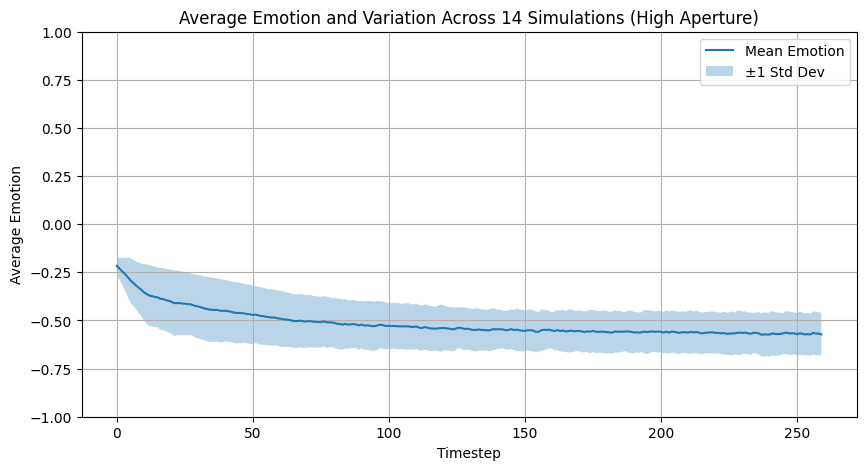

In [93]:
# Simple Statistics
style = 'High Aperture'
mean_emotion_per_timestep = dfHigh.iloc[:, 1:].mean(axis=1)
std_emotion_per_timestep = dfHigh.iloc[:, 1:].std(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(dfHigh.index, mean_emotion_per_timestep, label="Mean Emotion")
plt.fill_between(dfHigh.index,
                 mean_emotion_per_timestep - std_emotion_per_timestep,
                 mean_emotion_per_timestep + std_emotion_per_timestep,
                 alpha=0.3, label="±1 Std Dev")
plt.title(f"Average Emotion and Variation Across {runs} Simulations ({style})")
plt.xlabel("Timestep")
plt.ylabel("Average Emotion")
plt.ylim(-1, 1)
plt.legend()
plt.grid(True)
plt.show()

In [94]:
print(f"Mean: {mean_emotion_per_timestep}")
print(f"Std Dev: {std_emotion_per_timestep}")
cv_emotion_per_timestep = std_emotion_per_timestep / mean_emotion_per_timestep.abs()

sig_cv = cv_emotion_per_timestep[cv_emotion_per_timestep > 1]
if sig_cv.empty:
    print("No significant coefficient of variation found.")
else:
    print(sig_cv)

Mean: 0     -0.216279
1     -0.231252
2     -0.245341
3     -0.259468
4     -0.274774
         ...   
255   -0.572635
256   -0.563970
257   -0.568240
258   -0.568342
259   -0.571875
Length: 260, dtype: float64
Std Dev: 0      0.042775
1      0.057361
2      0.070481
3      0.085228
4      0.100005
         ...   
255    0.108884
256    0.112608
257    0.113104
258    0.113049
259    0.109753
Length: 260, dtype: float64
No significant coefficient of variation found.


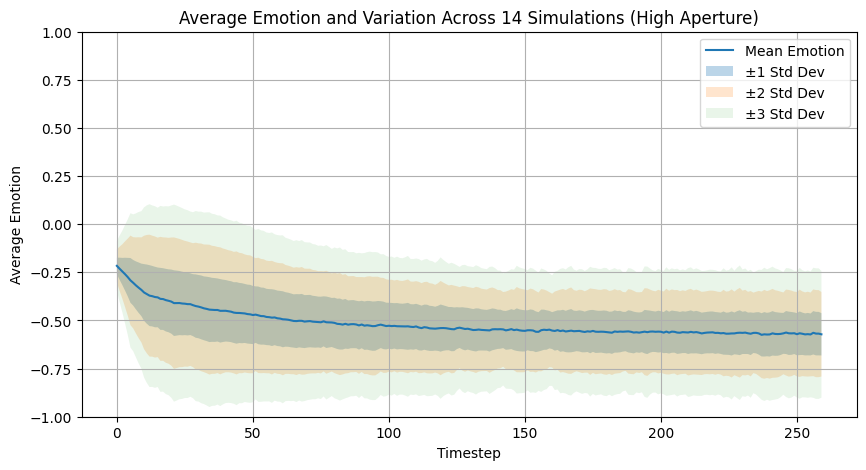

In [95]:
plt.figure(figsize=(10, 5))
plt.plot(dfHigh.index, mean_emotion_per_timestep, label="Mean Emotion")

# ±1 Std Dev
plt.fill_between(dfHigh.index,
                 mean_emotion_per_timestep - std_emotion_per_timestep,
                 mean_emotion_per_timestep + std_emotion_per_timestep,
                 alpha=0.3, label="±1 Std Dev")

# ±2 Std Dev
plt.fill_between(dfHigh.index,
                 mean_emotion_per_timestep - 2 * std_emotion_per_timestep,
                 mean_emotion_per_timestep + 2 * std_emotion_per_timestep,
                 alpha=0.2, label="±2 Std Dev")

# ±3 Std Dev
plt.fill_between(dfHigh.index,
                 mean_emotion_per_timestep - 3 * std_emotion_per_timestep,
                 mean_emotion_per_timestep + 3 * std_emotion_per_timestep,
                 alpha=0.1, label="±3 Std Dev")

plt.title(f"Average Emotion and Variation Across {runs} Simulations ({style})")
plt.xlabel("Timestep")
plt.ylabel("Average Emotion")
plt.ylim(-1, 1)
plt.legend()
plt.grid(True)
plt.show()

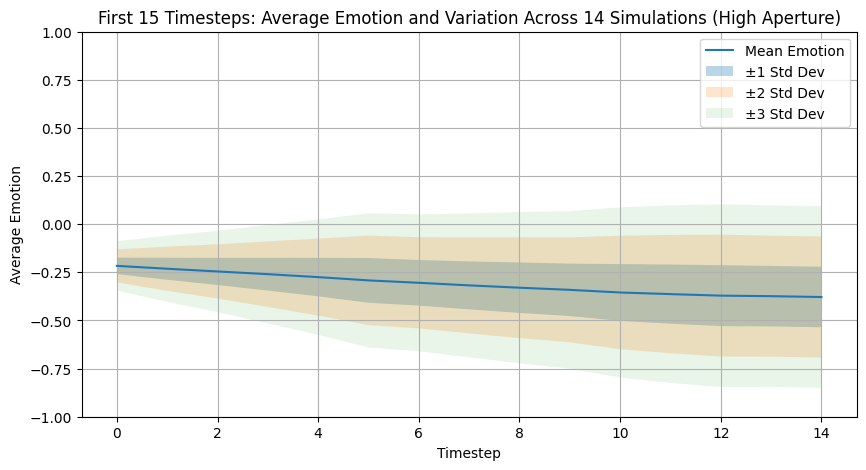

In [96]:
# Zooming in on the first 15 timesteps
df = dfHigh.iloc[:15,:]
mean_emotion_per_timestep = df.iloc[:, 1:].mean(axis=1)
std_emotion_per_timestep = df.iloc[:, 1:].std(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(df.index, mean_emotion_per_timestep, label="Mean Emotion")

# ±1 Std Dev
plt.fill_between(df.index,
                 mean_emotion_per_timestep - std_emotion_per_timestep,
                 mean_emotion_per_timestep + std_emotion_per_timestep,
                 alpha=0.3, label="±1 Std Dev")

# ±2 Std Dev
plt.fill_between(df.index,
                 mean_emotion_per_timestep - 2 * std_emotion_per_timestep,
                 mean_emotion_per_timestep + 2 * std_emotion_per_timestep,
                 alpha=0.2, label="±2 Std Dev")

# ±3 Std Dev
plt.fill_between(df.index,
                 mean_emotion_per_timestep - 3 * std_emotion_per_timestep,
                 mean_emotion_per_timestep + 3 * std_emotion_per_timestep,
                 alpha=0.1, label="±3 Std Dev")

plt.title(f"First 15 Timesteps: Average Emotion and Variation Across {runs} Simulations ({style})")
plt.xlabel("Timestep")
plt.ylabel("Average Emotion")
plt.ylim(-1, 1)
plt.legend()
plt.grid(True)
plt.show()


### Low Aperture

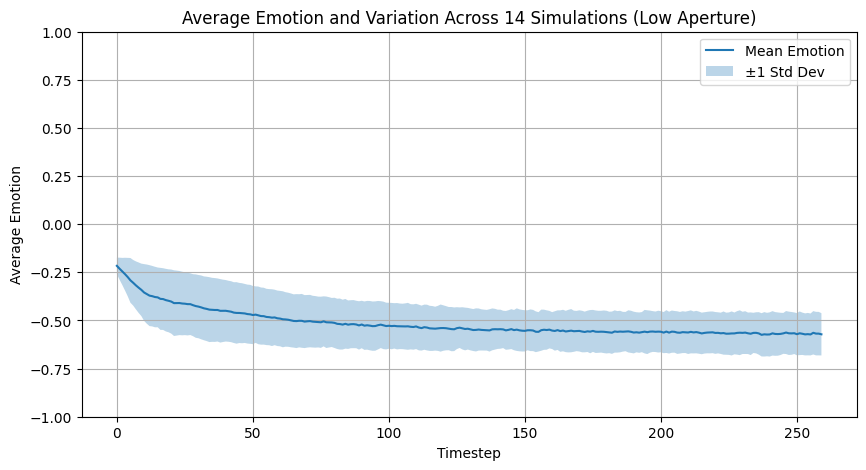

In [97]:
# Simple Statistics
style = 'Low Aperture'
mean_emotion_per_timestep = dfLow.iloc[:, 1:].mean(axis=1)
std_emotion_per_timestep = dfLow.iloc[:, 1:].std(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(dfLow.index, mean_emotion_per_timestep, label="Mean Emotion")
plt.fill_between(dfLow.index,
                 mean_emotion_per_timestep - std_emotion_per_timestep,
                 mean_emotion_per_timestep + std_emotion_per_timestep,
                 alpha=0.3, label="±1 Std Dev")
plt.title(f"Average Emotion and Variation Across {runs} Simulations ({style})")
plt.xlabel("Timestep")
plt.ylabel("Average Emotion")
plt.ylim(-1, 1)
plt.legend()
plt.grid(True)
plt.show()

In [98]:
print(f"Mean: {mean_emotion_per_timestep}")
print(f"Std Dev: {std_emotion_per_timestep}")
cv_emotion_per_timestep = std_emotion_per_timestep / mean_emotion_per_timestep.abs()

sig_cv = cv_emotion_per_timestep[cv_emotion_per_timestep > 1]
if sig_cv.empty:
    print("No significant coefficient of variation found.")
else:
    print(sig_cv)

Mean: 0     -0.216279
1     -0.231252
2     -0.245341
3     -0.259468
4     -0.274774
         ...   
255   -0.572635
256   -0.563970
257   -0.568240
258   -0.568342
259   -0.571875
Length: 260, dtype: float64
Std Dev: 0      0.042775
1      0.057361
2      0.070481
3      0.085228
4      0.100005
         ...   
255    0.108884
256    0.112608
257    0.113104
258    0.113049
259    0.109753
Length: 260, dtype: float64
No significant coefficient of variation found.


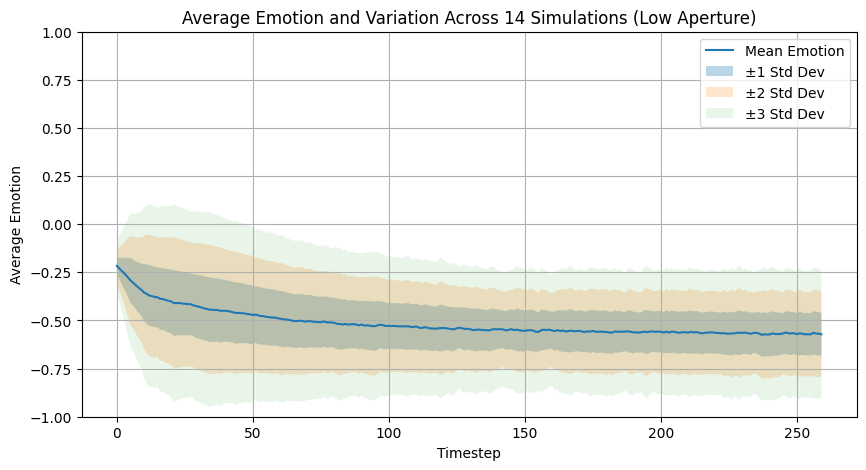

In [99]:
plt.figure(figsize=(10, 5))
plt.plot(dfLow.index, mean_emotion_per_timestep, label="Mean Emotion")

# ±1 Std Dev
plt.fill_between(dfLow.index,
                 mean_emotion_per_timestep - std_emotion_per_timestep,
                 mean_emotion_per_timestep + std_emotion_per_timestep,
                 alpha=0.3, label="±1 Std Dev")

# ±2 Std Dev
plt.fill_between(dfLow.index,
                 mean_emotion_per_timestep - 2 * std_emotion_per_timestep,
                 mean_emotion_per_timestep + 2 * std_emotion_per_timestep,
                 alpha=0.2, label="±2 Std Dev")

# ±3 Std Dev
plt.fill_between(dfLow.index,
                 mean_emotion_per_timestep - 3 * std_emotion_per_timestep,
                 mean_emotion_per_timestep + 3 * std_emotion_per_timestep,
                 alpha=0.1, label="±3 Std Dev")

plt.title(f"Average Emotion and Variation Across {runs} Simulations ({style})")
plt.xlabel("Timestep")
plt.ylabel("Average Emotion")
plt.ylim(-1, 1)
plt.legend()
plt.grid(True)
plt.show()

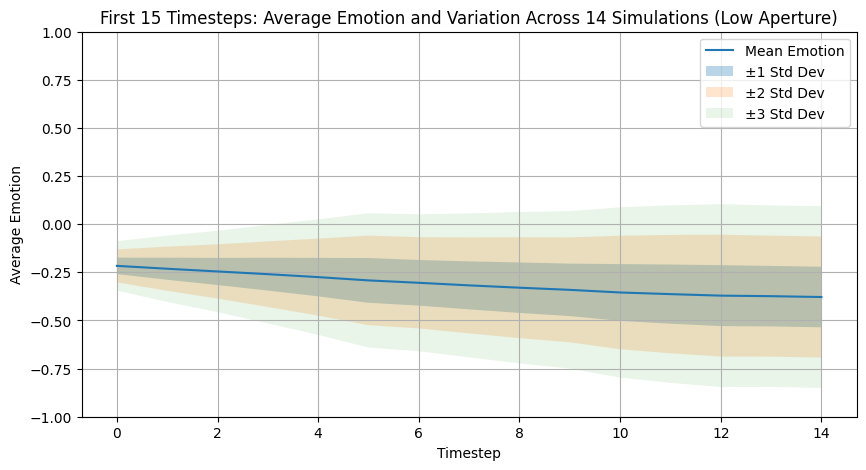

In [100]:
# Zooming in on the first 15 timesteps
df = dfLow.iloc[:15,:]
mean_emotion_per_timestep = df.iloc[:, 1:].mean(axis=1)
std_emotion_per_timestep = df.iloc[:, 1:].std(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(df.index, mean_emotion_per_timestep, label="Mean Emotion")

# ±1 Std Dev
plt.fill_between(df.index,
                 mean_emotion_per_timestep - std_emotion_per_timestep,
                 mean_emotion_per_timestep + std_emotion_per_timestep,
                 alpha=0.3, label="±1 Std Dev")

# ±2 Std Dev
plt.fill_between(df.index,
                 mean_emotion_per_timestep - 2 * std_emotion_per_timestep,
                 mean_emotion_per_timestep + 2 * std_emotion_per_timestep,
                 alpha=0.2, label="±2 Std Dev")

# ±3 Std Dev
plt.fill_between(df.index,
                 mean_emotion_per_timestep - 3 * std_emotion_per_timestep,
                 mean_emotion_per_timestep + 3 * std_emotion_per_timestep,
                 alpha=0.1, label="±3 Std Dev")

plt.title(f"First 15 Timesteps: Average Emotion and Variation Across {runs} Simulations ({style})")
plt.xlabel("Timestep")
plt.ylabel("Average Emotion")
plt.ylim(-1, 1)
plt.legend()
plt.grid(True)
plt.show()


## Structure Time!

We've got two lists of graphs, so keep in mind that the analysis we do might have to be done over all of them

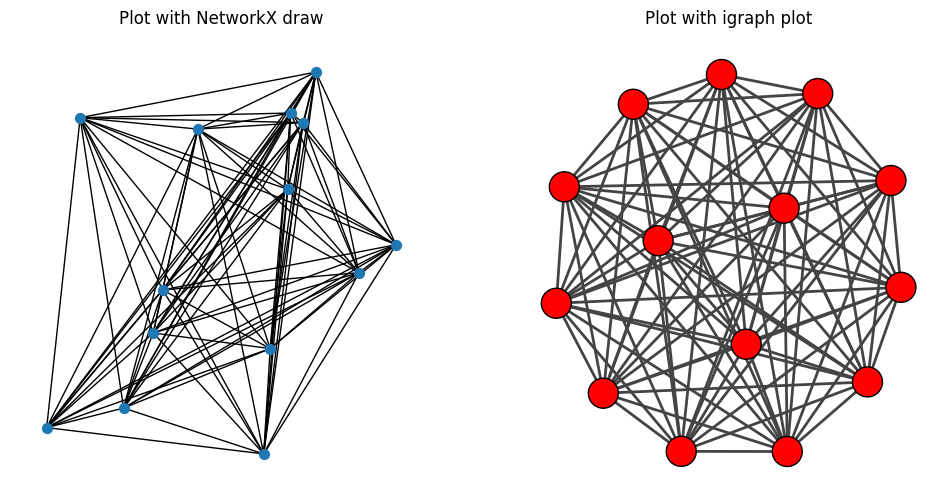

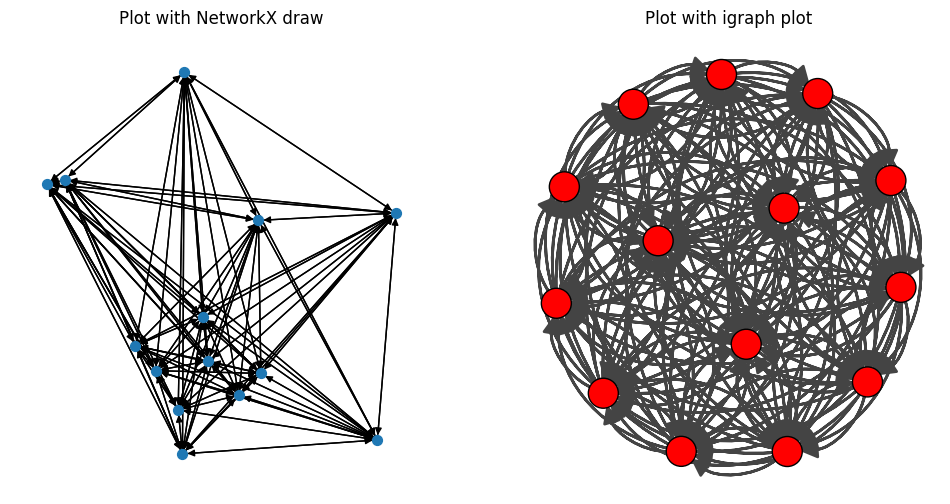

In [101]:
import igraph as ig
networkG = all_results_H.G_networks
networkDG = all_results_H.DG_networks

# convert to igraph
h = ig.Graph.from_networkx(networkG[2])  # using the third run's network for plotting

# Plot the same network with NetworkX and igraph
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# NetworkX draw
ax0.set_title("Plot with NetworkX draw")
nx.draw_kamada_kawai(networkG[2], node_size=50, ax=ax0)

# igraph draw
ax1.set_title("Plot with igraph plot")
layout = h.layout_kamada_kawai()
ig.plot(h, layout=layout, target=ax1)
plt.axis("off")
plt.show()


f = ig.Graph.from_networkx(networkDG[2])  # using the third run's network for plotting

# Plot the same network with NetworkX and igraph
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# NetworkX draw
ax0.set_title("Plot with NetworkX draw")
nx.draw_kamada_kawai(networkDG[2], node_size=50, ax=ax0)

# igraph draw
ax1.set_title("Plot with igraph plot")
layout = f.layout_kamada_kawai()
ig.plot(f, layout=layout, target=ax1)
plt.axis("off")
plt.show()

Focus on edge weights and tools using edge weights

Possible hypotheses:
- Does network structure affect intervention influence?  
***Since only one structure has been used as of yet, bipartite community, this question should be revised if it's to be used in the current paper unless another structure is tested. Alternatively, we could compare tight-bipartite and loose-bipartite (referring to the intra and inter strengths used for the intimacy matrix generation) since that would be quickest to test and compare.***

- Compare starting network and ending network

In [113]:
# -----------------------------
# 1. Weighted Degree / Strength
# -----------------------------
def compute_weighted_strength(graphs, directed=False):
    results = []
    for G in graphs:
        if directed:
            # DG_graphs should be passed here instead of G_graphs
            df = pd.DataFrame({
                'in_strength': dict(G.in_degree(weight='weight')).values(),
                'out_strength': dict(G.out_degree(weight='weight')).values()
            }, index=G.nodes)
        else:
            df = pd.DataFrame({
                'strength': dict(G.degree(weight='weight')).values()
            }, index=G.nodes)
        results.append(df)
    return results

# -----------------------------
# 2. Weighted Clustering
# -----------------------------
def compute_weighted_clustering(graphs):
    """
    Returns a list of Series with weighted clustering coefficient per node.
    Works for both directed and undirected graphs.
    """
    clustering_list = []
    for G in graphs:
        clustering_list.append(nx.clustering(G, weight='weight'))
    return clustering_list

# -----------------------------
# 3. Weighted Centrality
# -----------------------------
def compute_weighted_centrality(graphs, directed=True):
    """
    Returns dictionaries with closeness and betweenness centrality for each graph.
    """
    results_list = []
    for G in graphs:
        # For closeness, define distance as 1/weight so stronger intimacy = shorter distance
        length_dict = {}
        for u, v, d in G.edges(data=True):
            # avoid divide by zero
            d['distance'] = 1.0 / max(d.get('weight', 1e-6), 1e-6)
        closeness = nx.closeness_centrality(G, distance='distance')
        betweenness = nx.betweenness_centrality(G, weight='weight')
        results_list.append({'closeness': closeness, 'betweenness': betweenness})
    return results_list

# -----------------------------
# 4. Weighted Assortativity
# -----------------------------
def compute_weighted_assortativity(graphs):
    """
    Returns a list of weighted assortativity coefficients (degree-based).
    """
    assortativity_list = []
    for G in graphs:
        assortativity_list.append(nx.degree_pearson_correlation_coefficient(G, weight='weight'))
    return assortativity_list

# -----------------------------
# 5. Weighted Motif/Triad Analysis
# -----------------------------
def compute_weighted_triangles(graphs):
    """
    Returns a list with number of triangles weighted by edge weights for each node.
    """
    triangles_list = []
    for G in graphs:
        triangles_list.append(nx.triangles(G))  # Note: triadic counts ignore weights; for weighted, could use sum of weights in triads
    return triangles_list

# -----------------------------
# 6. Summary: visualize edge weights
# -----------------------------
def summarize_edge_weights(graphs):
    """
    Returns a DataFrame summarizing min, max, mean, std of edge weights per graph.
    """
    summary_list = []
    for i, G in enumerate(graphs):
        weights = [d['weight'] for u, v, d in G.edges(data=True)]
        df = pd.DataFrame({
            'graph_id': [i],
            'min_weight': [min(weights)],
            'max_weight': [max(weights)],
            'mean_weight': [sum(weights)/len(weights)],
            'std_weight': [pd.Series(weights).std()]
        })
        summary_list.append(df)
    return pd.concat(summary_list, ignore_index=True)


In [114]:
def full_network_analysis(batch_dict):
    """
    batch_dict: dictionary of the form
        {
            'wo': all_results_wo,
            'H': all_results_H,
            'L': all_results_L
        }
    Each value should have G_networks and DG_networks lists.
    
    Returns:
        analysis_results: nested dictionary with each measure per batch
    """
    analysis_results = {}

    for label, results in batch_dict.items():
        analysis_results[label] = {}

        G_graphs = results.G_networks
        DG_graphs = results.DG_networks

        # Weighted Strength
        analysis_results[label]['weighted_strength'] = compute_weighted_strength(G_graphs, directed=False)
        analysis_results[label]['weighted_strength_directed'] = compute_weighted_strength(DG_graphs, directed=True)


        # Weighted Clustering
        analysis_results[label]['weighted_clustering'] = compute_weighted_clustering(G_graphs)

        # Weighted Centrality
        analysis_results[label]['weighted_centrality'] = compute_weighted_centrality(DG_graphs, directed=True)

        # Weighted Assortativity
        analysis_results[label]['weighted_assortativity'] = compute_weighted_assortativity(G_graphs)

        # Weighted Triangles
        analysis_results[label]['weighted_triangles'] = compute_weighted_triangles(G_graphs)

        # Edge Weight Summary
        analysis_results[label]['edge_weight_summary'] = summarize_edge_weights(G_graphs)

    return analysis_results


In [ ]:
batches = {
    'wo': all_results_wo,
    'H': all_results_H,
    'L': all_results_L
}

analysis_results = full_network_analysis(batches)

In [116]:
for label, results in analysis_results.items():
    print(f"\nBatch: {label}")
    print(results['edge_weight_summary'])



Batch: wo
    graph_id  min_weight  max_weight  mean_weight  std_weight
0          0           1          54    22.956044   13.018715
1          1           1          54    22.967033   13.806158
2          2           1          63    23.747253   14.888917
3          3           2          57    23.516484   12.463603
4          4           1          55    23.692308   12.361852
5          5           3          63    23.549451   14.178437
6          6           3          61    23.351648   13.213103
7          7           2          52    22.164835   11.214340
8          8           1          60    23.846154   14.812850
9          9           2          73    23.120879   13.123207
10        10           2          62    22.142857   13.867285
11        11           1          72    23.043956   14.770024
12        12           1          65    22.923077   14.262796
13        13           1          53    22.923077   13.313511

Batch: H
    graph_id  min_weight  max_weight  mean_weight

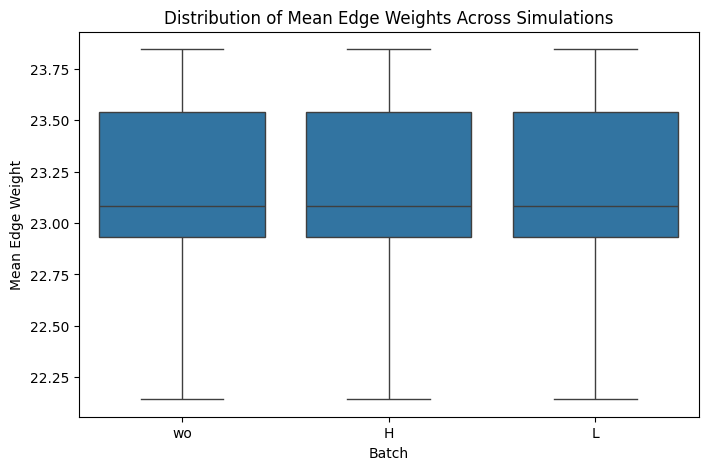

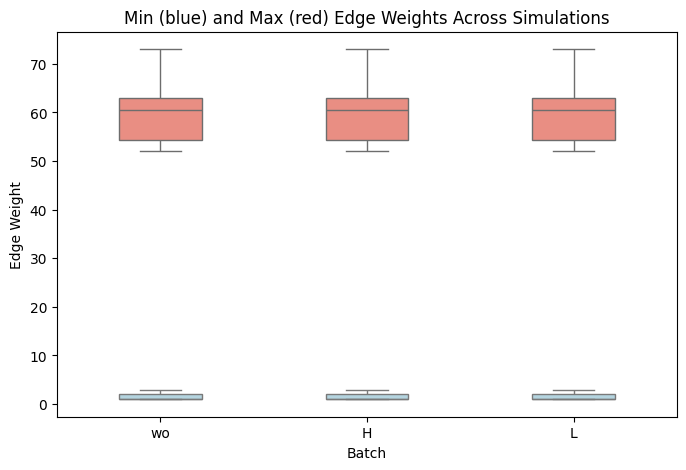

In [118]:
# Collect all edge weight summaries into one DataFrame with a batch label
all_summaries = []

for label, results in analysis_results.items():
    df = results['edge_weight_summary'].copy()
    df['batch'] = label
    all_summaries.append(df)

summary_df = pd.concat(all_summaries, ignore_index=True)

# Plot boxplots of mean edge weights per batch
plt.figure(figsize=(8,5))
sns.boxplot(x='batch', y='mean_weight', data=summary_df)
plt.title("Distribution of Mean Edge Weights Across Simulations")
plt.ylabel("Mean Edge Weight")
plt.xlabel("Batch")
plt.show()

# Optional: also plot min and max weights if you want full range comparison
plt.figure(figsize=(8,5))
sns.boxplot(x='batch', y='min_weight', data=summary_df, color='lightblue', width=0.4)
sns.boxplot(x='batch', y='max_weight', data=summary_df, color='salmon', width=0.4)
plt.title("Min (blue) and Max (red) Edge Weights Across Simulations")
plt.ylabel("Edge Weight")
plt.xlabel("Batch")
plt.show()


# Old Analysis
Can ignore , but I left it in case of any curiousity

In [102]:
# G: interaction frequency between agents
rows = []
for idx, G in enumerate(networkG):
    row = {"Simulation": idx}

    # Basic properties
    row["Node Count"] = G.number_of_nodes()
    row["Edge Count"] = G.number_of_edges()
    row["Density"] = nx.density(G)

    # Components
    row["Connected Components"] = nx.number_connected_components(G)

    # Clustering
    row["Transitivity"] = nx.transitivity(G)
    row["Avg Clustering"] = nx.average_clustering(G) # average clustering coefficient

    # Connectivity
    row['Node Connectivity'] = nx.node_connectivity(G)
    row['Average Node Connectivity'] = nx.average_node_connectivity(G)
    row['Edge Connectivity'] = nx.edge_connectivity(G)
    row["Avg Shortest Path"] = nx.average_shortest_path_length(G)
    row["Diameter"] = nx.diameter(G)
    row["Radius"] = nx.radius(G)

    # Communities
    try:
        communities_mod = list(nx.community.greedy_modularity_communities(G))
        row["# Modularity Communities"] = len(communities_mod)
    except:
        row["# Modularity Communities"] = None

    try:
        communities_label = list(nx.community.label_propagation_communities(G))
        row["# Label Communities"] = len(communities_label)
    except:
        row["# Label Communities"] = None

    rows.append(row)

# Create DataFrame
df = pd.DataFrame(rows)

# Display it nicely
print(df.to_string(index=False))

 Simulation  Node Count  Edge Count  Density  Connected Components  Transitivity  Avg Clustering  Node Connectivity  Average Node Connectivity  Edge Connectivity  Avg Shortest Path  Diameter  Radius  # Modularity Communities  # Label Communities
          0          14          91      1.0                     1           1.0             1.0                 13                       13.0                 13                1.0         1       1                         1                    1
          1          14          91      1.0                     1           1.0             1.0                 13                       13.0                 13                1.0         1       1                         1                    1
          2          14          91      1.0                     1           1.0             1.0                 13                       13.0                 13                1.0         1       1                         1                    1
          3     

In [103]:
# Per node measures:
node_rows = []
for idx, G in enumerate(networkG):
    try:
        deg_centrality = nx.degree_centrality(G)
        btw_centrality = nx.betweenness_centrality(G)
        cls_centrality = nx.closeness_centrality(G)
        eig_centrality = nx.eigenvector_centrality(G)
        triangles = nx.triangles(G)
        clustering = nx.clustering(G)
    except:
        continue  # if any centrality fails (e.g., eigenvector on disconnected graph)

    for node in G.nodes():
        row = {
            "Simulation": idx,
            "Node": node,
            "Degree Centrality": deg_centrality.get(node),
            "Betweenness Centrality": btw_centrality.get(node),
            "Closeness Centrality": cls_centrality.get(node),
            "Eigenvector Centrality": eig_centrality.get(node),
            "Triangle Count": triangles.get(node),
            "Clustering Coefficient": clustering.get(node),
        }
        node_rows.append(row)

# Create DataFrame
node_df = pd.DataFrame(node_rows)

# Display the full node-level table
print(node_df.to_string(index=False))

 Simulation  Node  Degree Centrality  Betweenness Centrality  Closeness Centrality  Eigenvector Centrality  Triangle Count  Clustering Coefficient
          0     0                1.0                     0.0                   1.0                0.267261              78                     1.0
          0     1                1.0                     0.0                   1.0                0.267261              78                     1.0
          0     2                1.0                     0.0                   1.0                0.267261              78                     1.0
          0     3                1.0                     0.0                   1.0                0.267261              78                     1.0
          0     4                1.0                     0.0                   1.0                0.267261              78                     1.0
          0     5                1.0                     0.0                   1.0                0.267261            

In [104]:
# DG: how much the agents influenced each other -- the cumaltive change in emotion valence, not the net-change in their emotion valence
rows = []
for idx, DG in enumerate(networkDG):
    row = {"Simulation": idx}

    # Basic properties
    row["Node Count"] = DG.number_of_nodes()
    row["Edge Count"] = DG.number_of_edges()
    row["Density"] = nx.density(DG)

    # Components
    row["Weakly Connected Components"] = nx.number_weakly_connected_components(DG)
    row["Strongly Connected Components"] = nx.number_strongly_connected_components(DG)

    # Clustering
    row["Transitivity"] = nx.transitivity(DG)
    row['Node Clustering'] = nx.clustering(DG)  # node clustering coefficient
    row["Avg Clustering"] = nx.average_clustering(DG) # average clustering coefficient

    # Connectivity
    row['Edge Connectivity'] = nx.edge_connectivity(DG)
    row["Avg Shortest Path"] = nx.average_shortest_path_length(DG)
    row["Diameter"] = nx.diameter(DG)
    row["Radius"] = nx.radius(DG)

    # Communities
    try:
        communities_mod = list(nx.community.greedy_modularity_communities(DG))
        row["# Modularity Communities"] = len(communities_mod)
    except:
        row["# Modularity Communities"] = None

    try:
        communities_label = list(nx.community.greedy_modularity_communities(DG))
        row["# Label Communities"] = len(communities_label)
    except:
        row["# Label Communities"] = None

    rows.append(row)

# Create DataFrame
df = pd.DataFrame(rows)

# Display it nicely
print(df.to_string(index=False))

 Simulation  Node Count  Edge Count  Density  Weakly Connected Components  Strongly Connected Components  Transitivity                                                                                                      Node Clustering  Avg Clustering  Edge Connectivity  Avg Shortest Path  Diameter  Radius  # Modularity Communities  # Label Communities
          0          14         182      1.0                            1                              1           1.0 {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0}             1.0                 13                1.0         1       1                         1                    1
          1          14         182      1.0                            1                              1           1.0 {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0}             1.0                 13                1.0 

In [105]:
# Per node measures:
node_rows = []
for idx, DG in enumerate(networkDG):
    try:
        deg_centrality = nx.degree_centrality(DG)
        btw_centrality = nx.betweenness_centrality(DG)
        cls_centrality = nx.closeness_centrality(DG)
        eig_centrality = nx.eigenvector_centrality(DG)
        clustering = nx.clustering(DG)
    except:
        continue  # if any centrality fails (e.g., eigenvector on disconnected graph)

    for node in DG.nodes():
        row = {
            "Simulation": idx,
            "Node": node,
            "Degree Centrality": deg_centrality.get(node),
            "Betweenness Centrality": btw_centrality.get(node),
            "Closeness Centrality": cls_centrality.get(node),
            "Eigenvector Centrality": eig_centrality.get(node),
            "Clustering Coefficient": clustering.get(node)
        }
        node_rows.append(row)

# Create DataFrame
node_df = pd.DataFrame(node_rows)

# Display the full node-level table
print(node_df.to_string(index=False))

 Simulation  Node  Degree Centrality  Betweenness Centrality  Closeness Centrality  Eigenvector Centrality  Clustering Coefficient
          0     0                2.0                     0.0                   1.0                0.267261                     1.0
          0     1                2.0                     0.0                   1.0                0.267261                     1.0
          0     2                2.0                     0.0                   1.0                0.267261                     1.0
          0     3                2.0                     0.0                   1.0                0.267261                     1.0
          0     4                2.0                     0.0                   1.0                0.267261                     1.0
          0     5                2.0                     0.0                   1.0                0.267261                     1.0
          0     6                2.0                     0.0                   1.0 